In [50]:
import numpy as np
import gensim
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.visualize_util import plot
from keras.utils.visualize_util import model_to_dot
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
import pickle
import pandas as pd

In [51]:
corpora = gensim.corpora.Dictionary.load('./data/corpora.dat')
print('Number of words in corpora: %d'%(len(corpora)))

Number of words in corpora: 26


In [52]:
tmp = list(corpora.items())

In [53]:
#the_filename = './data/wonderland.txt.dat'
the_filename = './data/test.txt.dat'
with open(the_filename, 'rb') as f:
    text = pickle.load(f)

### Generate words patterns - 2 words model

In [54]:
seq_length = 2

In [55]:
dataX = []
dataY = []
for i in range(0, len(text)-seq_length, 1):
    seq_in = text[i:i+seq_length]
    seq_out = text[i+seq_length]
    dataX.append(seq_in)
    dataY.append(seq_out)
    #tmp_seq_in = [corpora.id2token[value] for value in seq_in]
    #print(tmp_seq_in)
    #print(corpora.id2token[seq_out])

In [56]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (len(dataX), seq_length, 1))
# normalize
X = X / float(len(corpora))
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [57]:
print( 'dataY len: %d min: %d max: %d'%(len(dataY), np.min(dataY), np.max(dataY)))

dataY len: 28 min: 1 max: 25


In [58]:
y.shape

(28, 26)

### Create and fit the model

In [59]:
def create_model(fweights=None):
    batch_size = 1
    model = Sequential()
    model.add(LSTM(50, input_shape=(X.shape[1], 1)))
    model.add(Dense(y.shape[1], activation='softmax'))
    if fweights is not None:
        model.load_weights(fweights)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [60]:
model = create_model()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_5 (LSTM)                    (None, 50)            10400       lstm_input_5[0][0]               
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 26)            1326        lstm_5[0][0]                     
Total params: 11726
____________________________________________________________________________________________________


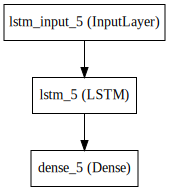

In [61]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Train the model

In [62]:
# checkpoint
filepath="dev_jason_statefull_LSTM_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

model.fit(X, y, nb_epoch=500, batch_size=1, verbose=2, callbacks=[checkpoint])
# summarize performance of the model

Epoch 1/500
Epoch 00000: acc improved from -inf to 0.00000, saving model to dev_jason_statefull_LSTM_weights.best.hdf5
0s - loss: 3.2765 - acc: 0.0000e+00
Epoch 2/500
Epoch 00001: acc did not improve
0s - loss: 3.2491 - acc: 0.0000e+00
Epoch 3/500
Epoch 00002: acc improved from 0.00000 to 0.07143, saving model to dev_jason_statefull_LSTM_weights.best.hdf5
0s - loss: 3.2319 - acc: 0.0714
Epoch 4/500
Epoch 00003: acc did not improve
0s - loss: 3.2171 - acc: 0.0714
Epoch 5/500
Epoch 00004: acc did not improve
0s - loss: 3.2014 - acc: 0.0714
Epoch 6/500
Epoch 00005: acc did not improve
0s - loss: 3.1846 - acc: 0.0714
Epoch 7/500
Epoch 00006: acc did not improve
0s - loss: 3.1675 - acc: 0.0714
Epoch 8/500
Epoch 00007: acc did not improve
0s - loss: 3.1492 - acc: 0.0714
Epoch 9/500
Epoch 00008: acc did not improve
0s - loss: 3.1303 - acc: 0.0714
Epoch 10/500
Epoch 00009: acc did not improve
0s - loss: 3.1097 - acc: 0.0714
Epoch 11/500
Epoch 00010: acc did not improve
0s - loss: 3.0936 - acc:

In [63]:
scores = model.evaluate(X, y, verbose=0)
print("Model Accuracy: %.2f%%" % (scores[1]*100))

Model Accuracy: 92.86%


In [64]:
model.save('./models/dev_jason_statefull_LSTM.h5')

### Demonstrate some model predictions

In [65]:
# load weights
model = create_model("dev_jason_statefull_LSTM_weights.best.hdf5")
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_6 (LSTM)                    (None, 50)            10400       lstm_input_6[0][0]               
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 26)            1326        lstm_6[0][0]                     
Total params: 11726
____________________________________________________________________________________________________


### Test model

In [66]:
max_len = 2
def get_next(inp):
    idxs = [corpora.token2id[c] for c in inp]
    idxs = np.reshape(idxs, (1, max_len, 1))
    idxs = idxs / float(len(corpora))
    prediction = model.predict(idxs, verbose=0)
    index = np.argmax(prediction)
    result = corpora.id2token[index]
    return result

In [67]:
get_next(['One', 'two'])

'three'

In [68]:
test_cases_text = pd.read_csv('./data/test_cases_text.csv')
pred = []
for index, row in test_cases_text.iterrows():
    #print( '%s %s'%(row['in_0'], row['in_1']))
    inp = [row['in_0'], row['in_1']]
    #print(inp)
    tmp = get_next(inp)
    pred.append(tmp)
test_cases_text['predicted'] = pred

In [69]:
test_cases_text[test_cases_text.out!=test_cases_text.predicted]

,in_0,in_1,out,predicted
23,you,?,What,you
26,are,you,doing,?


In [70]:
true_cnt = len(test_cases_text[test_cases_text.out==test_cases_text.predicted].index) * 1.0
all_cnt = len(test_cases_text.index) * 1.0
print('True cnt: %d All cnt %d'%(true_cnt, all_cnt))
print("Precision: %.2f"%( true_cnt/all_cnt))

True cnt: 26 All cnt 28
Precision: 0.93
